In [4]:
# --- Персональный модуль для хранения функций --- #
import proj_func as pf

# --- Общедоступный набор модулей --- #
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import re
import pandas.plotting
import pytesseract
import os
#from pixellib.torchbackend.instance import instanceSegmentation
#-------------------------------------#


#В ходе обработки видеофайлов будет использоваться Tesseract-OCR (Optical Char's Recognition)
#поэтому нужно явно указать директорию местонахождения его "движка":
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

#Инициализируем некоторые гиперпараметры нашей системы:
FPS_CUT = 100 #Не стоит использовать, съедаются моменты заходов в комнаты
tt_coef = 0.2
config='--oem 3 --psm 6'
video_path = 'train/video/'
data_path = 'train/data/'
WIDTH = 1920   #Параметры подобраны из соображений обучения модели под параметры видеокамеры,
HEIGHT = 1080  #распознавание людей и читаемости Даты\Время с помощью Tesseract-OCR
do_train = False
devourer = True
pict_check = False
analyze_data = True
refix_data = True

#Инициализируем наш CSV-DataSet в переменную train_data:
if os.path.exists(os.path.join(data_path, 'fixed_train_data.csv')) == False or refix_data == True:

    train_data = pd.read_csv(os.path.join(data_path, 'train_data.csv'), delimiter=',')

    # Сделаем данные в DataSet'е изотропными относительно данных для каждого столбца (избавимся от артефактов):
    train_data = pf.correct_data(train_data)
    if os.path.exists(os.path.join(data_path, 'fixed_train_data.csv')) == False:
        train_data.to_csv(os.path.join(data_path, 'fixed_train_data.csv'))
else:
    train_data = pd.read_csv(os.path.join(data_path, 'fixed_train_data.csv'), delimiter=',')

Обрабатываем данные:
----------------
Типы численных данных были изменены!
--------
Артефакты времени были исправлены!
--------
Исправленные ошибки времени:
По часам []
По минутам ['13:59:60']
По секундам ['13:59:60', '13:55:60', '13:55:61', '13:55:61', '13:55:64']
--------
ID были исправлены!
--------
----------------


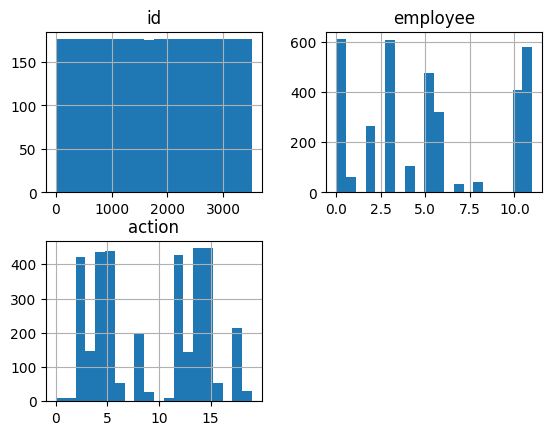

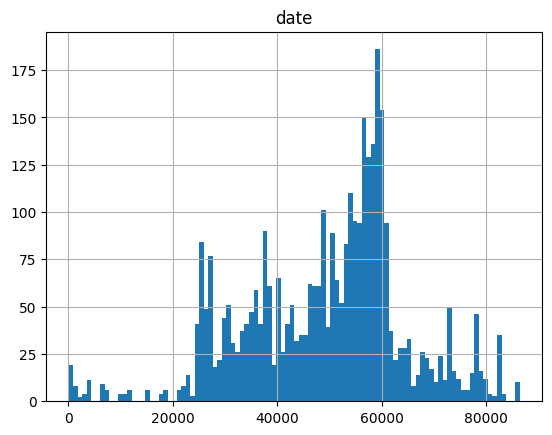

date        1.000000
employee    0.210985
id          0.138837
action      0.017887
Name: date, dtype: float64


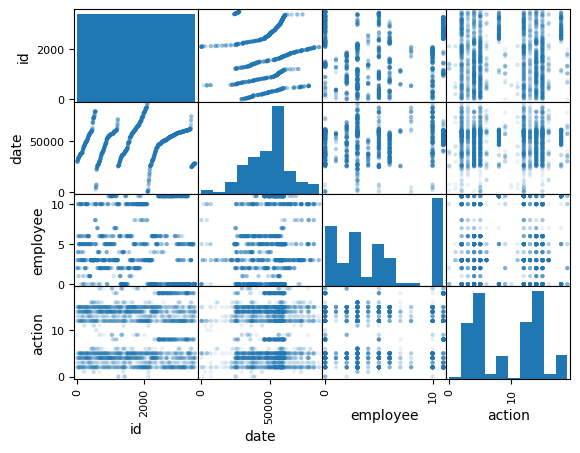

In [2]:
#Рассмотрим особенности нашего DataSet'а:
if analyze_data == True:
    #1. Оценим полноту данных:
    addition_data = pd.DataFrame(train_data['date'].apply(lambda x: pf.time_transformator(x.split(' ')[1])))

    train_data.hist(bins = 20)
    plt.show()

    addition_data.hist(bins = 100)
    plt.show()

    #2. Из корелляции по Пирсону видна некоторая линейная зависимость
    #действия некоторого человека от времени ~0.21
    train_data_1 = train_data.copy()
    train_data_1['date'] = addition_data
    corr_matrix = train_data_1.corr()
    print(corr_matrix['date'].sort_values(ascending=False))

    #3. Предлагаю рассмотреть также Scatter_Matrix:
    pandas.plotting.scatter_matrix(train_data_1, alpha = 0.1)
    plt.show()
    del train_data_1
    #Видно, что некоторые данные немного разрежены, а значит, если качество модели в метрике "Recall"
    #будет неудовлетворительно, то стоит заняться нормализацией

#В ходе машинного обучения необходимо иметь изотропный DataSet, чтобы
#модель смогла иметь более высокую производительность после обучения
#Поэтому ниже идёт проверка на кол-во файлов в папке с обучающими видео:
#1. Если файл один в директории, то инициализируем его
if len([x for x in os.listdir(video_path)]) == 1:
    train_video = list(cv2.VideoCapture(os.path.join(video_path, os.listdir(video_path)[0])))
#2. Если видеофайлов несколько, то необходимо инициализировать их последовательно
else:
    train_videos = list(cv2.VideoCapture(os.path.join(video_path, x))
                  for x in os.listdir(video_path))

In [ ]:
#Перед запуском видео введём "переключатель", который
#определит ЕДИНОЖДЫ геометрические рамки поиска данных Дата\Время из видео:
switcher = False
#model = instanceSegmentation()
#model.load_model('pointrend_resnet50.pkl')

#classes_model = model.select_target_classes(person=True)

counter = 0 #Голод "Пожирателя" - Экспериментальный параметр для упрощения обучения модели
try:
    for train_video in train_videos:
        while True:
            _, main_frame = train_video.read()
            counter += 1 #Инкремент "Пожирателя"
            if switcher == False:
                main_frame = cv2.resize(main_frame, (WIDTH, HEIGHT))
                data = pytesseract.image_to_data(main_frame, config=config)          #Определяем ВСЕ тексты
                data = data.splitlines()
                for el in data:
                    if re.findall(r'..:..:..', el) == []:                       #Поиск времени
                        pass
                    else:
                        e = el.split()
                        x_t, y_t, w_t, h_t = int(e[6]), int(e[7]), int(e[8]), int(e[9])

                    if re.findall(r'..[-]..[-]....', el) == []:                 #Поиск даты
                        continue
                    else:
                        e = el.split()
                        x_d, y_d, w_d, h_d = int(e[6]), int(e[7]), int(e[8]), int(e[9])
                switcher = True
                continue

            frame = main_frame.copy()

            #Структура "Пожиратель", определяющая, сколько кадров будет пропущено в видеофайле:
            if devourer == True and counter % FPS_CUT != 0:       #Показывает себя более стабильно
                continue                #нежели метод "set" класса VideoCapture

            #Для более упрощённого обучения модели перейдём с тензора 1280x720x3 -> на матрицу 1280x720x1:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, (WIDTH,HEIGHT))
            main_frame = cv2.resize(main_frame, (WIDTH, HEIGHT))

            # Экспериментально подобранные параметры для Tesseract-OCR, которые
            # ОТЛИЧНО читают данные из видеокадров:
            thresh_time = frame[y_t - 4:y_t + h_t + 4, x_t:x_t + w_t]
            thresh_date = frame[y_d - 4:y_d + h_d + 4, x_d:x_d + w_d + 4]
            _, thresh_time = cv2.threshold(thresh_time, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            _, thresh_date = cv2.threshold(thresh_date, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            thresh_time = cv2.blur(thresh_time, (5, 5))
            thresh_date = cv2.blur(thresh_date, (5, 5))

            #Имеем точные геометрические рамки наших данных Дата\Время:
            date_now = pytesseract.image_to_string(thresh_date, config=config)
            time_now = pytesseract.image_to_string(thresh_time, config=config)

            dt = pf.normalize_dt(date_now, time_now)

            if do_train == False:
                dt_color_main = (255, 255, 255)
                dt_color_shadow = (100, 100, 100)
                if pict_check == True:  # Условие сохранения последних снимков наших Даты и Времени (для визуальной оценки)
                    cv2.imwrite('thresh_time.png', thresh_time)
                    cv2.imwrite('thresh_date.png', thresh_date)
                #Для более красивой визуализации определим прямоугольные рамки наиболее важных для нас параметров (Дата\Время):
                rect_t = cv2.rectangle(main_frame, (x_t, y_t), (x_t+w_t, y_t+h_t), (0,0,255), 2)
                rect_d = cv2.rectangle(main_frame, (x_d, y_d), (x_d + w_d, y_d + h_d), (0, 0, 255), 2)
                date_text_shadow = cv2.putText(main_frame, 'Date: ' + dt[0], (x_d + 2, y_d - 2),
                                               cv2.FONT_HERSHEY_SIMPLEX,
                                               fontScale=0.5, color=dt_color_shadow, thickness=2)
                time_text_shadow = cv2.putText(main_frame, 'Time: ' + dt[1], (x_t + 2, y_t - 2),
                                               cv2.FONT_HERSHEY_SIMPLEX,
                                               fontScale=0.5, color=dt_color_shadow, thickness=2)
                date_text = cv2.putText(main_frame, 'Date: ' + dt[0], (x_d, y_d-2),cv2.FONT_HERSHEY_SIMPLEX,
                                        fontScale = 0.5, color = dt_color_main, thickness = 2)
                time_text = cv2.putText(main_frame, 'Time: ' + dt[1], (x_t, y_t-2), cv2.FONT_HERSHEY_SIMPLEX,
                                        fontScale=0.5, color= dt_color_main, thickness=2)


                #Отображение кадра! Наконец-то...
                #model.segmentFrame(main_frame, segment_target_classes=classes_model, show_bboxes=True)
                print(counter)
                counter = 0

            #Условие-закрытие окна через кнокпку "q" - quit:
            if cv2.waitKey(1) == ord('q'):
                1/0
            #Условие-открытие следующего видеофайла "n" - next:
            if cv2.waitKey(110) == ord('n'):
                break
except ZeroDivisionError:
    pass

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
